# Installing the Dependencies

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow
from nltk.corpus import stopwords
from numpy import array
from keras import layers
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

# Loading Dataset

In [3]:
movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv")

In [4]:

movie_reviews.shape

(50000, 2)

In [5]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<Axes: xlabel='sentiment', ylabel='count'>

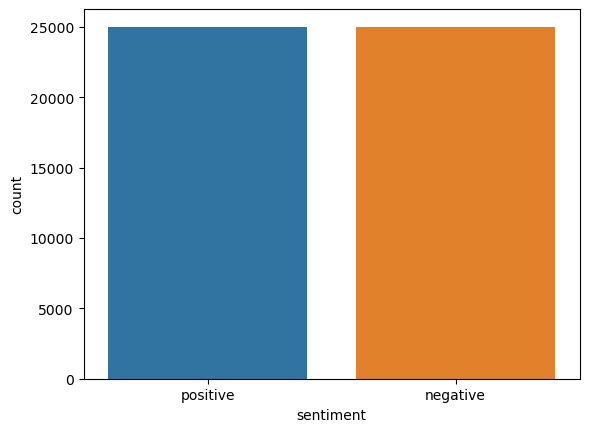

In [6]:
import seaborn as sns
sns.countplot(x= 'sentiment', data = movie_reviews)

# Preprocessing The Data

In [7]:
movie_reviews['review'][3]
#As we can see the review contains HTML tags , numbers , Punctuations which can be a problem for Neural Network

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [8]:
#Removing the HTML tags
regex_object = re.compile(r'<[^>]+>')
def remove_tags(text):
  "Removes html tags by replacing anything between < and > by a whitespace "
  return regex_object.sub('',text)

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\MIR
[nltk_data]     FAISAL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [11]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
  cleaned_text = preprocess_text(sen)
  X.append(cleaned_text)

In [12]:
#Sample Cleaned Up movie review
X[3]

'basically family little boy jake thinks zombie closet parents fighting time movie slower soap opera suddenly jake decides become rambo kill zombie ok first going make film must decide thriller drama drama movie watchable parents divorcing arguing like real life jake closet totally ruins film expected see boogeyman similar movie instead watched drama meaningless thriller spots well playing parents descent dialogs shots jake ignore '

In [13]:
#Converting Sentiment labels to 0 & 1
y = movie_reviews['sentiment']
lambda x : 1 if x== 'positive' else 0
y = np.array(list(map(lambda x : 1 if x== 'positive' else 0,y)))
print(y)

[1 1 1 ... 0 0 0]


In [14]:
X_train , X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20,random_state =42 )

# Preparing Embedding Layer

In [15]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

from keras.preprocessing.text import Tokenizer
tokenizer_object = Tokenizer()
tokenizer_object.fit_on_texts(X_train)
X_train = tokenizer_object.texts_to_sequences(X_train)
X_test = tokenizer_object.texts_to_sequences(X_test)


In [16]:
# +1 is added for adding an extra dimension of words that are not in the vocabulary
vocab_length  = len(tokenizer_object.word_index) + 1 # word index returns a dictionary where each key is a word and its value is its index
vocab_length

92394

In [17]:
#padding all reviews to fixed length
max_len = 100
X_train = pad_sequences(X_train, padding = 'post', maxlen = max_len)
X_test = pad_sequences(X_test, padding = 'post', maxlen = max_len)


In [18]:
# Loading Glove Word Embedding and Creating a Embedding dictionary
from numpy import asarray
embedding_dict = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding = "utf8")
for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = asarray(records[1:],dtype = 'float32')
  embedding_dict[word] = vector_dimensions
glove_file.close()

In [19]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.
# 100 Features of each Word

from numpy import zeros
embedding_matrix = zeros((vocab_length,100))
for word , index in tokenizer_object.word_index.items(): #.word_index returns a dictionary of keys and their corresponding indexes and . items displays the key and index pairs
  embedding_vector = embedding_dict.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [20]:
print("The embedding matrix has a shape of ", embedding_matrix.shape)

The embedding matrix has a shape of  (92394, 100)


In [21]:
for i in range(1,6):
  row_representation = f"word at index{i}: {embedding_matrix[i]}"
  print(row_representation)
 # Displaying the first few rows and columns for illustration

word at index1: [ 0.38251001  0.14821     0.60601002 -0.51533002  0.43992001  0.061053
 -0.62716001 -0.025385    0.16429999 -0.22101     0.14422999 -0.37213001
 -0.21683    -0.08895     0.097904    0.65609998  0.64455003  0.47698
  0.83849001  1.64859998  0.88922    -0.1181     -0.012465   -0.52082002
  0.77854002  0.48723    -0.014991   -0.14127    -0.34746999 -0.29595
  0.1028      0.57191002 -0.045594    0.026443    0.53816003  0.32257
  0.40788001 -0.043599   -0.146      -0.48346001  0.32036     0.55085999
 -0.76258999  0.43268999  0.61752999 -0.36502999 -0.60598999 -0.79615003
  0.39289999 -0.23668    -0.34718999 -0.61201     0.54746997  0.94812
  0.20941    -2.77710009 -0.60219997  0.8495      1.25489998  0.017893
 -0.041901    2.11470008 -0.026618   -0.28104001  0.68124002 -0.14165001
  0.99248999  0.49879    -0.67537999  0.64170003  0.42302999 -0.27913001
  0.063403    0.68909001 -0.36183     0.053709   -0.16806     0.19422001
 -0.47073001 -0.14803    -0.58986002 -0.27970001  0

# MODEL TRAINING WITH:

# Simple Neural Network:

In [22]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length,100,weights = [embedding_matrix],input_length= max_len,trainable = False)
snn_model.add(embedding_layer)
snn_model.add(Flatten())
snn_model.add(Dense(1,activation = 'sigmoid'))


In [23]:
snn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
print(snn_model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9249401 (35.28 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [24]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size = 128,epochs = 6 , verbose = 1,validation_split = 0.2)

Epoch 1/6


250/250 [==============================] - 3s 9ms/step - loss: 0.5579 - acc: 0.7128 - val_loss: 0.5131 - val_acc: 0.7465
Epoch 2/6
250/250 [==============================] - 2s 7ms/step - loss: 0.4485 - acc: 0.7948 - val_loss: 0.4991 - val_acc: 0.7650
Epoch 3/6
250/250 [==============================] - 2s 9ms/step - loss: 0.4120 - acc: 0.8162 - val_loss: 0.5101 - val_acc: 0.7630
Epoch 4/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3899 - acc: 0.8292 - val_loss: 0.5176 - val_acc: 0.7549
Epoch 5/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3744 - acc: 0.8368 - val_loss: 0.5429 - val_acc: 0.7533
Epoch 6/6
250/250 [==============================] - 2s 7ms/step - loss: 0.3614 - acc: 0.8438 - val_loss: 0.5298 - val_acc: 0.7575


In [25]:
score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.5559 - acc: 0.7491


In [26]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5559400916099548
Test Accuracy: 0.7491000294685364


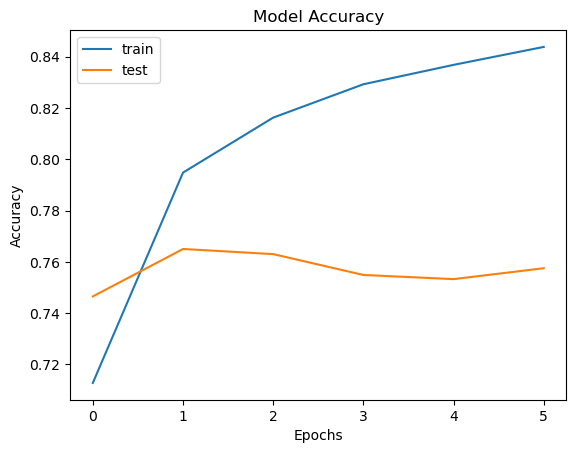

<function matplotlib.pyplot.show(close=None, block=None)>

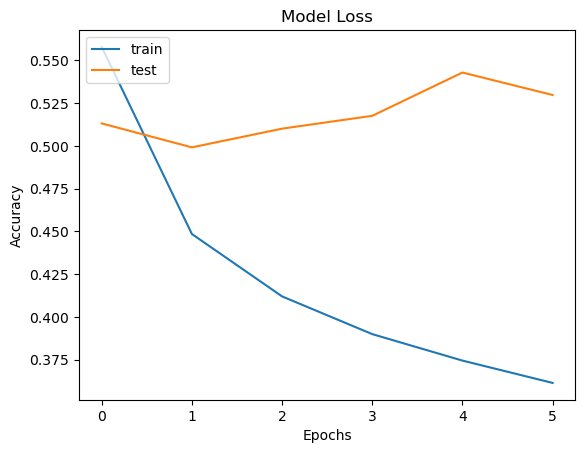

In [27]:
#Model Performance Chart
import matplotlib.pyplot as plt
plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','test'], loc = 'upper left')
plt.show

In [28]:
prediction = snn_model.predict(X_test)


313/313 [==============================] - 1s 2ms/step


In [29]:
single_review = "This is a brilliant and fantastic movie!, I really love it."
tokenized_review = tokenizer_object.texts_to_sequences([single_review])
padded_review = pad_sequences(tokenized_review, maxlen=max_len)

# Make a prediction for the single review
prediction = snn_model.predict(padded_review)
print(prediction)

1/1 [==============================] - 0s 31ms/step
[[0.6840465]]


In [30]:
threshold = 0.5
if prediction[0, 0] > threshold:
    print("Review is positive!")
else:
    print("Review is negative.")

Review is positive!


# Convolutional Neural Network

In [31]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=max_len , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [32]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9303657 (35.49 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [33]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 8s 31ms/step - loss: 0.4877 - acc: 0.7654 - val_loss: 0.3879 - val_acc: 0.8291
Epoch 2/6
250/250 [==============================] - 8s 33ms/step - loss: 0.3491 - acc: 0.8520 - val_loss: 0.3523 - val_acc: 0.8447
Epoch 3/6
250/250 [==============================] - 9s 36ms/step - loss: 0.2920 - acc: 0.8825 - val_loss: 0.3437 - val_acc: 0.8478
Epoch 4/6
250/250 [==============================] - 10s 42ms/step - loss: 0.2501 - acc: 0.9062 - val_loss: 0.3747 - val_acc: 0.8321
Epoch 5/6
250/250 [==============================] - 9s 35ms/step - loss: 0.2095 - acc: 0.9258 - val_loss: 0.3314 - val_acc: 0.8530
Epoch 6/6
250/250 [==============================] - 8s 31ms/step - loss: 0.1746 - acc: 0.9444 - val_loss: 0.3452 - val_acc: 0.8485


In [34]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 2s 6ms/step - loss: 0.3434 - acc: 0.8464


In [35]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3434046506881714
Test Accuracy: 0.8464000225067139


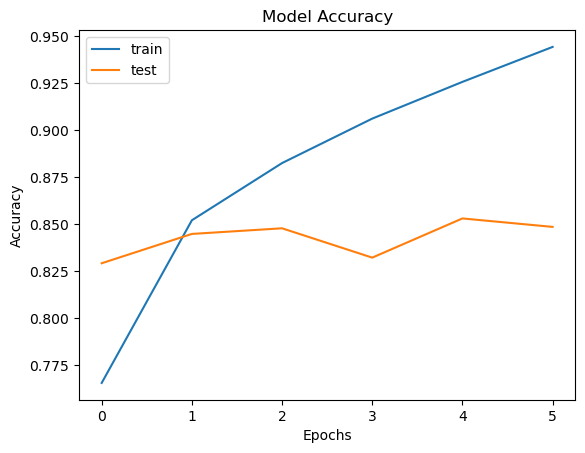

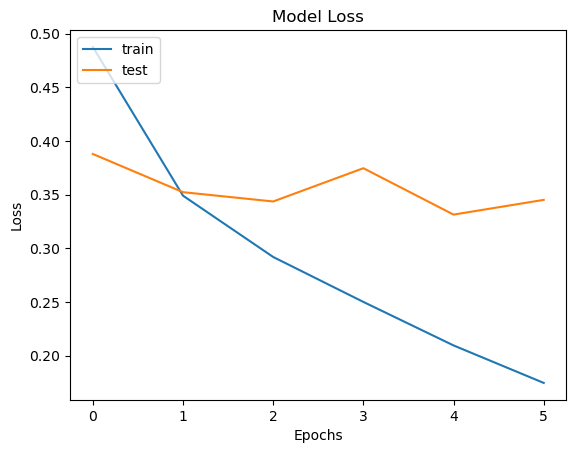

In [39]:
plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','test'],loc ='upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','test'],loc ='upper left')
plt.show()

In [40]:
#Making a Prediction
single_review = "This is a brilliant and fantastic movie!, I really love it."
tokenized_review = tokenizer_object.texts_to_sequences([single_review])
padded_review = pad_sequences(tokenized_review, maxlen=max_len)

# Make a prediction for the single review
prediction = cnn_model.predict(padded_review)
print(prediction)

1/1 [==============================] - 0s 31ms/step
[[0.999931]]


In [41]:
threshold = 0.5
if prediction[0,0] > 0.5:
  print("This is a Positive Review")
else:
  print("This is a Negative Review")

This is a Positive Review


# LSTM Model


In [42]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length,100,weights = [embedding_matrix], input_length = max_len, trainable = False)
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))
lstm_model.add(Dense(1,activation = 'sigmoid'))


In [43]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [44]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 39s 147ms/step - loss: 0.4993 - acc: 0.7554 - val_loss: 0.4111 - val_acc: 0.8127
Epoch 2/6
250/250 [==============================] - 34s 137ms/step - loss: 0.4121 - acc: 0.8180 - val_loss: 0.3700 - val_acc: 0.8418
Epoch 3/6
250/250 [==============================] - 36s 142ms/step - loss: 0.3682 - acc: 0.8397 - val_loss: 0.3498 - val_acc: 0.8556
Epoch 4/6
250/250 [==============================] - 36s 143ms/step - loss: 0.3451 - acc: 0.8530 - val_loss: 0.3383 - val_acc: 0.8569
Epoch 5/6
250/250 [==============================] - 40s 159ms/step - loss: 0.3241 - acc: 0.8649 - val_loss: 0.3331 - val_acc: 0.8630
Epoch 6/6
250/250 [==============================] - 38s 154ms/step - loss: 0.3088 - acc: 0.8715 - val_loss: 0.3339 - val_acc: 0.8684


In [45]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 6s 18ms/step - loss: 0.3356 - acc: 0.8649


In [46]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3356218934059143
Test Accuracy: 0.8648999929428101


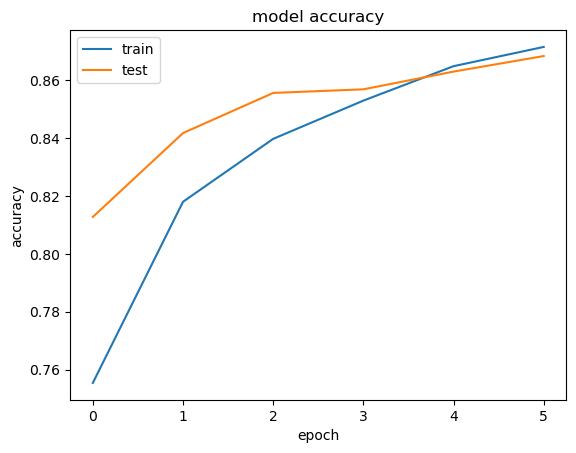

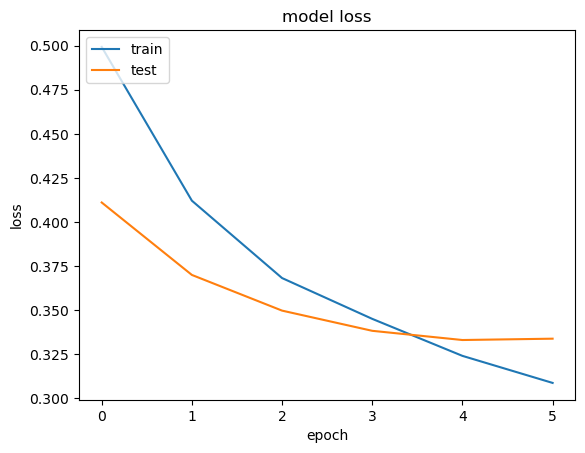

In [47]:

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [56]:
#Making a Prediction
single_review = "This is a brilliant and fantastic movie!, I really love it."
tokenized_review = tokenizer_object.texts_to_sequences([single_review])
padded_review = pad_sequences(tokenized_review, maxlen=max_len)

# Make a prediction for the single review
prediction = lstm_model.predict(padded_review)
print(prediction)

1/1 [==============================] - 1s 600ms/step
[[0.96236247]]


In [49]:
threshold = 0.5
if prediction[0,0] > 0.5:
  print("This is a Positive Review")
else:
  print("This is a Negative Review")

This is a Positive Review


# Making Predictions on live IMdb Data


In [51]:
sample_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [52]:
unseen_reviews = sample_reviews['Review Text']
unseen_processed = []
for review in unseen_reviews:
    review = preprocess_text(review)
    unseen_processed.append(review)

In [55]:
#tokenize using earlier tokenizer
unseen_tokenize = tokenizer_object.texts_to_sequences(unseen_processed)

unseen_padded = pad_sequences(unseen_tokenize, padding='post', maxlen=max_len)

In [57]:
unseen_sentiments = lstm_model.predict(unseen_padded)
unseen_sentiments

1/1 [==============================] - 0s 48ms/step


array([[0.92891395],
       [0.9914617 ],
       [0.19854426],
       [0.90221405],
       [0.9755099 ],
       [0.03381387]], dtype=float32)

In [58]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,9.3
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,2.0
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,9.0
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.8
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.3
